In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Datas

In [3]:
spacy_eng = spacy.load("en")

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir

        self.df = pd.read_csv(captions_file, error_bad_lines=False, names=['image', 'caption'], header=None, sep='\t')
        self.transform = transform
        # Get img, caption columns
        self.df["image"] = self.df["image"].apply(lambda x: self.removeNumbers(x))
        self.imgs = self.df["image"]
        self.df.sample(frac=1)

        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
    def removeNumbers(self, image):
          image = image.split('#')[0]
          check = image.split('.')
          if len(check)>2:
            image = check[0]+"."+check[1]
          return image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [6]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [7]:
def get_loader(
    root_folder,annotation_file,transform,batch_size=32,
    num_workers=8,shuffle=True,pin_memory=True,):
  
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

#### implementing Networks

In [8]:
class BahdanauAttention(nn.Module):

    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(DecoderRNN, self).__init__()
        self.num_features = num_features
        self.embedding_dim = embed_size
        self.hidden_dim = hidden_size
        self.vocab_size = vocab_size
        self.sample_temp = 0.5

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + num_features, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = BahdanauAttention(num_features, hidden_size)
        self.drop = nn.Dropout(0.5)
        self.init_h = nn.Linear(num_features, hidden_size)
        self.init_c = nn.Linear(num_features, hidden_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions, sample_prob = 0.0):
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = embed.size(1)
        feature_size = features.size(1)
        batch_size = embed.size(0)
        
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

        for t in range(seq_len):

            word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
            
        return outputs, atten_weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    def greedy_search(self, features, vocabulary, max_sentence = 40):

        sentence = []
        weights = []
        input_word = torch.tensor([vocabulary.stoi['<SOS>']]).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = torch.tensor(top_idx)
            if (len(sentence) >= max_sentence or top_idx == vocabulary.stoi['<EOS>']):
                break
        return sentence, weights


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, num_features)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs, _ = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=40):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image)
            sentence, weights = self.decoderRNN.greedy_search(x, vocabulary, max_sentence = max_length)

        return [vocabulary.itos[idx] for idx in sentence]


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0



#### Training

In [9]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False


# Hyperparameters
batch_size = 64
embed_size = 256
hidden_size = 512
num_features = 2048
num_layers = 1
learning_rate = 1e-4
momentum = 0.9
num_epochs = 20



transform = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])



train_loader, dataset = get_loader(
    root_folder="/content/drive/My Drive/Deep/HW03/Q03/Datas/Flicker8k_Dataset",
    annotation_file="/content/drive/My Drive/Deep/HW03/Q03/Datas/Flickr8k.token.txt",
    transform=transform,
    num_workers=2,
    batch_size=batch_size,
)

vocab_size = len(dataset.vocab)


# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, num_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [10]:
def train(print_every):

    
    for epoch in range(num_epochs):
        model.train()
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)
        step = 0

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)
            captions = captions.permute(1,0)
            
            outputs = model(imgs, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))

            stats = '  Loss = %.4f' % (loss.item())
            if step % print_every == 0:
              print('\r' + stats)


            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

        model.eval()
        plt.imshow(imgs[0].cpu().permute(1,2,0))
        plt.show()
        predicted_caption = model.caption_image(imgs[0].unsqueeze(0), dataset.vocab)
        print("\n"+" ".join(predicted_caption))

  0%|          | 1/633 [00:50<8:49:41, 50.29s/it]

  Loss = 8.0033


  2%|▏         | 11/633 [01:36<59:29,  5.74s/it]

  Loss = 6.8001


  3%|▎         | 21/633 [02:21<50:43,  4.97s/it]

  Loss = 5.8562


  5%|▍         | 31/633 [03:02<42:37,  4.25s/it]

  Loss = 5.3541


  6%|▋         | 41/633 [03:43<42:41,  4.33s/it]

  Loss = 5.0095


  8%|▊         | 51/633 [04:22<37:20,  3.85s/it]

  Loss = 4.6950


 10%|▉         | 61/633 [04:58<34:08,  3.58s/it]

  Loss = 4.5896


 11%|█         | 71/633 [05:29<31:21,  3.35s/it]

  Loss = 4.4916


 13%|█▎        | 81/633 [05:59<29:48,  3.24s/it]

  Loss = 4.2352


 14%|█▍        | 91/633 [06:28<25:26,  2.82s/it]

  Loss = 4.1731


 16%|█▌        | 101/633 [06:57<26:56,  3.04s/it]

  Loss = 4.2562


 18%|█▊        | 111/633 [07:21<21:57,  2.52s/it]

  Loss = 3.9917


 19%|█▉        | 121/633 [07:47<20:52,  2.45s/it]

  Loss = 3.8065


 21%|██        | 131/633 [08:11<18:42,  2.24s/it]

  Loss = 3.8603


 22%|██▏       | 141/633 [08:34<18:15,  2.23s/it]

  Loss = 3.7770


 24%|██▍       | 151/633 [08:57<20:34,  2.56s/it]

  Loss = 3.5812


 25%|██▌       | 161/633 [09:18<14:55,  1.90s/it]

  Loss = 3.4623


 27%|██▋       | 171/633 [09:37<14:38,  1.90s/it]

  Loss = 3.5396


 29%|██▊       | 181/633 [09:55<14:36,  1.94s/it]

  Loss = 3.3846


 30%|███       | 191/633 [10:16<15:43,  2.13s/it]

  Loss = 3.3234


 32%|███▏      | 201/633 [10:31<10:40,  1.48s/it]

  Loss = 3.2145


 33%|███▎      | 211/633 [10:47<10:10,  1.45s/it]

  Loss = 3.2604


 35%|███▍      | 221/633 [11:02<09:57,  1.45s/it]

  Loss = 3.3144


 36%|███▋      | 231/633 [11:17<10:30,  1.57s/it]

  Loss = 3.0983


 38%|███▊      | 241/633 [11:31<09:15,  1.42s/it]

  Loss = 3.0168


 40%|███▉      | 251/633 [11:44<08:50,  1.39s/it]

  Loss = 3.2333


 41%|████      | 261/633 [11:58<08:32,  1.38s/it]

  Loss = 2.9863


 43%|████▎     | 271/633 [12:12<08:33,  1.42s/it]

  Loss = 2.8420


 44%|████▍     | 281/633 [12:27<08:34,  1.46s/it]

  Loss = 2.7466


 46%|████▌     | 291/633 [12:41<08:08,  1.43s/it]

  Loss = 2.6601


 48%|████▊     | 301/633 [12:56<07:56,  1.44s/it]

  Loss = 2.9351


 49%|████▉     | 311/633 [13:10<07:26,  1.39s/it]

  Loss = 2.7240


 51%|█████     | 321/633 [13:24<07:23,  1.42s/it]

  Loss = 2.6839


 52%|█████▏    | 331/633 [13:38<07:03,  1.40s/it]

  Loss = 2.7067


 54%|█████▍    | 341/633 [13:52<06:41,  1.38s/it]

  Loss = 2.5838


 55%|█████▌    | 351/633 [14:06<06:38,  1.41s/it]

  Loss = 2.4928


 57%|█████▋    | 361/633 [14:20<06:28,  1.43s/it]

  Loss = 2.5334


 59%|█████▊    | 371/633 [14:34<06:00,  1.38s/it]

  Loss = 2.7796


 60%|██████    | 381/633 [14:48<05:54,  1.41s/it]

  Loss = 2.5801


 62%|██████▏   | 391/633 [15:02<05:44,  1.42s/it]

  Loss = 2.3795


 63%|██████▎   | 401/633 [15:17<05:26,  1.41s/it]

  Loss = 2.5215


 65%|██████▍   | 411/633 [15:31<05:16,  1.42s/it]

  Loss = 2.4250


 67%|██████▋   | 421/633 [15:45<04:53,  1.38s/it]

  Loss = 2.5339


 68%|██████▊   | 431/633 [15:59<04:45,  1.41s/it]

  Loss = 2.3301


 70%|██████▉   | 441/633 [16:13<04:30,  1.41s/it]

  Loss = 2.2808


 71%|███████   | 451/633 [16:28<04:23,  1.45s/it]

  Loss = 2.3674


 73%|███████▎  | 461/633 [16:42<04:16,  1.49s/it]

  Loss = 2.3822


 74%|███████▍  | 471/633 [16:56<03:46,  1.40s/it]

  Loss = 2.3265


 76%|███████▌  | 481/633 [17:10<03:33,  1.40s/it]

  Loss = 2.1943


 78%|███████▊  | 491/633 [17:24<03:14,  1.37s/it]

  Loss = 2.1203


 79%|███████▉  | 501/633 [17:38<03:05,  1.41s/it]

  Loss = 2.1316


 81%|████████  | 511/633 [17:52<02:55,  1.44s/it]

  Loss = 2.2665


 82%|████████▏ | 521/633 [18:07<02:38,  1.42s/it]

  Loss = 2.2538


 84%|████████▍ | 531/633 [18:21<02:26,  1.43s/it]

  Loss = 2.0278


 85%|████████▌ | 541/633 [18:35<02:11,  1.43s/it]

  Loss = 1.9785


 87%|████████▋ | 551/633 [18:49<01:53,  1.39s/it]

  Loss = 2.1953


 89%|████████▊ | 561/633 [19:04<01:42,  1.42s/it]

  Loss = 1.9763


 90%|█████████ | 571/633 [19:18<01:27,  1.40s/it]

  Loss = 2.1975


 92%|█████████▏| 581/633 [19:31<01:12,  1.39s/it]

  Loss = 1.9976


 93%|█████████▎| 591/633 [19:45<00:58,  1.39s/it]

  Loss = 1.8594


 95%|█████████▍| 601/633 [19:59<00:46,  1.44s/it]

  Loss = 2.1386


 97%|█████████▋| 611/633 [20:13<00:31,  1.41s/it]

  Loss = 1.8794


 98%|█████████▊| 621/633 [20:28<00:17,  1.42s/it]

  Loss = 2.0077


100%|█████████▉| 631/633 [20:42<00:02,  1.38s/it]

  Loss = 2.1007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


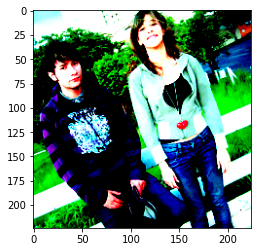


<SOS> two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 1/633 [00:02<27:45,  2.63s/it]

  Loss = 1.9748


  2%|▏         | 11/633 [00:16<14:49,  1.43s/it]

  Loss = 1.8959


  3%|▎         | 21/633 [00:30<14:17,  1.40s/it]

  Loss = 1.8430


  5%|▍         | 31/633 [00:45<14:24,  1.44s/it]

  Loss = 1.8970


  6%|▋         | 41/633 [00:59<14:03,  1.42s/it]

  Loss = 1.9039


  8%|▊         | 51/633 [01:13<13:58,  1.44s/it]

  Loss = 1.9310


 10%|▉         | 61/633 [01:27<13:34,  1.42s/it]

  Loss = 1.8694


 11%|█         | 71/633 [01:41<12:58,  1.39s/it]

  Loss = 1.8291


 13%|█▎        | 81/633 [01:55<12:47,  1.39s/it]

  Loss = 1.8687


 14%|█▍        | 91/633 [02:09<12:46,  1.41s/it]

  Loss = 1.7437


 16%|█▌        | 101/633 [02:23<12:19,  1.39s/it]

  Loss = 1.7034


 18%|█▊        | 111/633 [02:37<12:00,  1.38s/it]

  Loss = 1.6568


 19%|█▉        | 121/633 [02:52<12:07,  1.42s/it]

  Loss = 1.7670


 21%|██        | 131/633 [03:06<11:37,  1.39s/it]

  Loss = 1.5335


 22%|██▏       | 141/633 [03:20<11:20,  1.38s/it]

  Loss = 1.6974


 24%|██▍       | 151/633 [03:34<11:13,  1.40s/it]

  Loss = 1.7672


 25%|██▌       | 161/633 [03:48<11:24,  1.45s/it]

  Loss = 1.6980


 27%|██▋       | 171/633 [04:02<10:57,  1.42s/it]

  Loss = 1.7351


 29%|██▊       | 181/633 [04:17<10:50,  1.44s/it]

  Loss = 1.6495


 30%|███       | 191/633 [04:31<10:35,  1.44s/it]

  Loss = 1.6521


 32%|███▏      | 201/633 [04:45<10:06,  1.40s/it]

  Loss = 1.5325


 33%|███▎      | 211/633 [04:59<09:56,  1.41s/it]

  Loss = 1.7905


 35%|███▍      | 221/633 [05:13<09:52,  1.44s/it]

  Loss = 1.4308


 36%|███▋      | 231/633 [05:27<09:35,  1.43s/it]

  Loss = 1.5818


 38%|███▊      | 241/633 [05:41<09:07,  1.40s/it]

  Loss = 1.5626


 40%|███▉      | 251/633 [05:56<09:05,  1.43s/it]

  Loss = 1.5629


 41%|████      | 261/633 [06:10<09:08,  1.47s/it]

  Loss = 1.5838


 43%|████▎     | 271/633 [06:24<08:37,  1.43s/it]

  Loss = 1.4784


 44%|████▍     | 281/633 [06:38<08:17,  1.41s/it]

  Loss = 1.4943


 46%|████▌     | 291/633 [06:52<08:09,  1.43s/it]

  Loss = 1.6009


 48%|████▊     | 301/633 [07:07<07:48,  1.41s/it]

  Loss = 1.3880


 49%|████▉     | 311/633 [07:20<07:18,  1.36s/it]

  Loss = 1.5884


 51%|█████     | 321/633 [07:34<07:16,  1.40s/it]

  Loss = 1.5649


 52%|█████▏    | 331/633 [07:48<07:03,  1.40s/it]

  Loss = 1.4742


 54%|█████▍    | 341/633 [08:03<07:11,  1.48s/it]

  Loss = 1.5430


 55%|█████▌    | 351/633 [08:17<06:32,  1.39s/it]

  Loss = 1.4529


 57%|█████▋    | 361/633 [08:31<06:26,  1.42s/it]

  Loss = 1.5334


 59%|█████▊    | 371/633 [08:45<06:17,  1.44s/it]

  Loss = 1.4500


 60%|██████    | 381/633 [08:59<05:55,  1.41s/it]

  Loss = 1.4658


 62%|██████▏   | 391/633 [09:13<05:36,  1.39s/it]

  Loss = 1.4604


 63%|██████▎   | 401/633 [09:28<05:30,  1.43s/it]

  Loss = 1.4142


 65%|██████▍   | 411/633 [09:42<05:13,  1.41s/it]

  Loss = 1.3761


 67%|██████▋   | 421/633 [09:56<05:00,  1.42s/it]

  Loss = 1.4427


 68%|██████▊   | 431/633 [10:10<04:36,  1.37s/it]

  Loss = 1.4415


 70%|██████▉   | 441/633 [10:23<04:23,  1.37s/it]

  Loss = 1.3901


 71%|███████   | 451/633 [10:37<04:16,  1.41s/it]

  Loss = 1.2947


 73%|███████▎  | 461/633 [10:52<04:04,  1.42s/it]

  Loss = 1.2415


 74%|███████▍  | 471/633 [11:06<03:45,  1.39s/it]

  Loss = 1.4474


 76%|███████▌  | 481/633 [11:20<03:33,  1.41s/it]

  Loss = 1.4117


 78%|███████▊  | 491/633 [11:33<03:16,  1.38s/it]

  Loss = 1.2134


 79%|███████▉  | 501/633 [11:47<03:06,  1.41s/it]

  Loss = 1.2647


 81%|████████  | 511/633 [12:02<02:55,  1.44s/it]

  Loss = 1.2012


 82%|████████▏ | 521/633 [12:16<02:36,  1.40s/it]

  Loss = 1.3706


 84%|████████▍ | 531/633 [12:30<02:25,  1.43s/it]

  Loss = 1.3263


 85%|████████▌ | 541/633 [12:44<02:11,  1.43s/it]

  Loss = 1.1922


 87%|████████▋ | 551/633 [12:59<01:58,  1.44s/it]

  Loss = 1.3422


 89%|████████▊ | 561/633 [13:12<01:41,  1.41s/it]

  Loss = 1.2684


 90%|█████████ | 571/633 [13:26<01:27,  1.42s/it]

  Loss = 1.1465


 92%|█████████▏| 581/633 [13:40<01:11,  1.38s/it]

  Loss = 1.3541


 93%|█████████▎| 591/633 [13:55<01:01,  1.45s/it]

  Loss = 1.2076


 95%|█████████▍| 601/633 [14:09<00:45,  1.43s/it]

  Loss = 1.2090


 97%|█████████▋| 611/633 [14:23<00:30,  1.40s/it]

  Loss = 1.1418


 98%|█████████▊| 621/633 [14:37<00:16,  1.39s/it]

  Loss = 1.1467


100%|█████████▉| 631/633 [14:51<00:02,  1.40s/it]

  Loss = 1.2729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


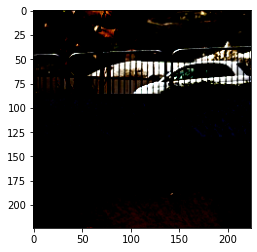


<SOS> two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two two


  0%|          | 1/633 [00:02<29:34,  2.81s/it]

  Loss = 1.2243


  2%|▏         | 11/633 [00:16<14:40,  1.42s/it]

  Loss = 1.1650


  3%|▎         | 21/633 [00:30<14:28,  1.42s/it]

  Loss = 1.1261


  5%|▍         | 31/633 [00:44<14:00,  1.40s/it]

  Loss = 1.1694


  6%|▋         | 41/633 [00:58<13:49,  1.40s/it]

  Loss = 1.1778


  8%|▊         | 51/633 [01:12<13:18,  1.37s/it]

  Loss = 1.1842


 10%|▉         | 61/633 [01:26<13:30,  1.42s/it]

  Loss = 1.3225


 11%|█         | 71/633 [01:40<13:01,  1.39s/it]

  Loss = 1.2166


 13%|█▎        | 81/633 [01:54<12:51,  1.40s/it]

  Loss = 1.2998


 14%|█▍        | 91/633 [02:09<12:55,  1.43s/it]

  Loss = 1.1004


 16%|█▌        | 101/633 [02:23<12:36,  1.42s/it]

  Loss = 1.1837


 18%|█▊        | 111/633 [02:36<12:10,  1.40s/it]

  Loss = 1.1326


 19%|█▉        | 121/633 [02:50<11:46,  1.38s/it]

  Loss = 1.2483


 21%|██        | 131/633 [03:04<11:37,  1.39s/it]

  Loss = 1.2462


 22%|██▏       | 141/633 [03:18<11:25,  1.39s/it]

  Loss = 1.1214


 24%|██▍       | 151/633 [03:32<11:13,  1.40s/it]

  Loss = 1.0801


 25%|██▌       | 161/633 [03:46<11:07,  1.41s/it]

  Loss = 1.1927


 27%|██▋       | 171/633 [04:01<11:06,  1.44s/it]

  Loss = 0.9804


 29%|██▊       | 181/633 [04:15<10:41,  1.42s/it]

  Loss = 1.1025


 30%|███       | 191/633 [04:29<10:11,  1.38s/it]

  Loss = 1.0817


 32%|███▏      | 201/633 [04:43<10:21,  1.44s/it]

  Loss = 1.0327


 33%|███▎      | 211/633 [04:58<10:09,  1.44s/it]

  Loss = 1.0928


 35%|███▍      | 221/633 [05:11<09:31,  1.39s/it]

  Loss = 1.0526


 36%|███▋      | 231/633 [05:26<09:47,  1.46s/it]

  Loss = 1.0653


 38%|███▊      | 241/633 [05:40<09:20,  1.43s/it]

  Loss = 1.0337


 40%|███▉      | 251/633 [05:54<08:54,  1.40s/it]

  Loss = 0.9877


 41%|████      | 261/633 [06:08<08:48,  1.42s/it]

  Loss = 1.0976


 43%|████▎     | 271/633 [06:22<08:17,  1.37s/it]

  Loss = 1.0059


 44%|████▍     | 281/633 [06:36<08:30,  1.45s/it]

  Loss = 0.9467


 45%|████▌     | 288/633 [06:46<08:08,  1.42s/it]

In [ ]:
train(10)